In [127]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

from transformers import pipeline
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF


In [5]:
# Leer el archivo .parquet
df = pd.read_parquet('IA.parquet')

In [6]:
df.head()

,store,assigned_at,answer
0,FN60,2023-02-20 12:25:30.652022,"Todo lo hacen perfecto,, gracias por su atención"
1,FN54,2023-02-20 17:10:31.230531,Ya no ay probadores
2,T060,2023-02-21 18:55:32.949118,Excelente servicio
3,FN88,2023-02-24 16:25:54.015137,Buen servicio
4,T036,2023-02-21 19:25:33.154527,EL personal disperso y eso que estaba solo el ...


In [7]:
df.nunique()

store            65
assigned_at    7519
answer         7368
dtype: int64

In [8]:
# Algunos comentarios
for i in [1,24,6456,235,257,555,799,152,53,24,633]:
    print(df["answer"][i])

Ya no ay probadores
La ropa es exelente 
El producto excelente la atención muy mala. Los asesores parecen maniqui  no motivan al cliente 
Son excelente felicitaciones 
Exelente producto y servicio 
Tengo una inquietud
A mi hijo le compré un ganan muy lindo lo uso una par de veces pero ya le quedó pequeño habrá la posibilidad de entregarlo como parte de pago para adquirir una prenda que se ajuste a su talla.
buena opción y precio
Todo excelente 
Me parecen excelentes las ofertas y la atención muy buena
La ropa es exelente 
Mas descuentos.$


In [9]:
# Preprocesamiento de texto
def limpiar_texto(texto):
    try:
        texto = texto.lower()  # Convertir a minúsculas
        texto = re.sub(r'\d+', '', texto)  # Eliminar números
        texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar signos de puntuación
        texto = re.sub(r'\s+', ' ', texto)  # Eliminar espacios adicionales
        return texto
    except:
        return ""

In [10]:
df["answer_clean"] = df["answer"].apply(limpiar_texto)

In [11]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Brahi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Brahi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stop_words = set(stopwords.words('spanish'))

In [13]:
# Tokenización y eliminación de stopwords
def tokenizar(texto):
    tokens = word_tokenize(texto)
    tokens_limpios = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens_limpios)

df['answer_tokenizado'] = df['answer_clean'].apply(tokenizar)

In [14]:
df.head(3)

,store,assigned_at,answer,answer_clean,answer_tokenizado
0,FN60,2023-02-20 12:25:30.652022,"Todo lo hacen perfecto,, gracias por su atención",todo lo hacen perfecto gracias por su atención,hacen perfecto gracias atención
1,FN54,2023-02-20 17:10:31.230531,Ya no ay probadores,ya no ay probadores,ay probadores
2,T060,2023-02-21 18:55:32.949118,Excelente servicio,excelente servicio,excelente servicio


Una vez ya procesado los comentarios o respuestas de los clientes, utilizaremos un modelo preentrenado para el analisis de sentimiento de Hugging Face.

In [16]:
# Cargar el modelo de análisis de sentimientos en español
sentiment_analysis = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

c:\Users\Brahi\Documents\GitHub\prueba_tecnica_data_science\Modelo de IA\entorno_IA\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Brahi\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
# Analizar sentimientos
df['sentimiento'] = df['answer_tokenizado'].apply(lambda x: sentiment_analysis(x)[0]['label'])

In [20]:
# df.to_csv('IA_sentimientos.csv', index=False)
# df = pd.read_csv('IA_sentimientos.csv')

In [40]:
print("Por ejemplo este cliente tuvo el siguiente comentario:\n"+
      str(df[["answer_tokenizado","sentimiento"]].iloc[4][0])+
      "\npor lo que el sentimiento asociado fue: "+ str(df.iloc[4,5])
      )

Por ejemplo este cliente tuvo el siguiente comentario:
personal disperso solo almacen pasan grupitos conversando almacen sola salida chequeen bolsa factura humillante dos veces comprar mismo día
por lo que el sentimiento asociado fue: 1 star


C:\Users\Brahi\AppData\Local\Temp\ipykernel_1220\3022856167.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  str(df[["answer_tokenizado","sentimiento"]].iloc[4][0])+


En general el modelo pareciera tener una muy buena precision

In [42]:
df[["answer_tokenizado","sentimiento"]]

,answer_tokenizado,sentimiento
0,hacen perfecto gracias atención,5 stars
1,ay probadores,5 stars
2,excelente servicio,5 stars
3,buen servicio,5 stars
4,personal disperso solo almacen pasan grupitos ...,1 star
...,...,...
9365,continúen calidad actual diseños prendas cool,5 stars
9366,lindo innovador,5 stars
9367,mala atencion personal,1 star
9368,gracias,5 stars


Observemos como se clasifican los comentarios de 1 a 5, recordando que 1 es muy negativo y 5 muy positivo

<Axes: xlabel='sentimiento', ylabel='count'>

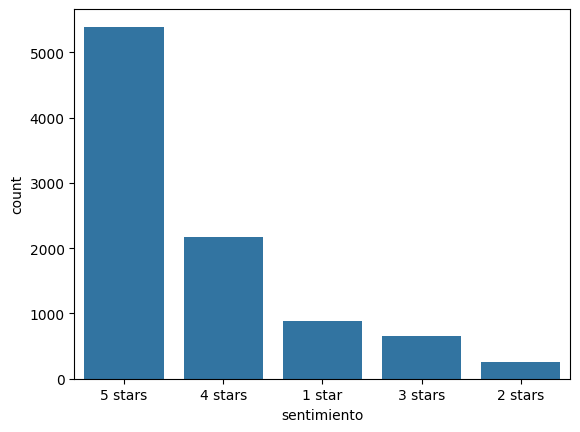

In [48]:
counts = df['sentimiento'].value_counts()

# Luego, convertimos el índice a una lista ordenada en orden descendente
order = counts.index.tolist()

# Finalmente, pasamos esa lista al argumento 'order' de sns.countplot
sns.countplot(data=df, x='sentimiento', order=order)

Tal parece que la mayoria de los comentarios de los clientes son positivos.

Organicemos el formato de la fecha:

In [55]:
df["assigned_at"] = pd.to_datetime(df["assigned_at"], format='%Y-%m-%d %H:%M:%S.%f')

In [58]:
# FECHA MÁS ANTIGUA
df["assigned_at"].min()

Timestamp('2022-01-02 11:45:56.643000')

In [60]:
# FECHA MÁS RECIENTE
df["assigned_at"].max()

Timestamp('2024-05-06 15:10:16.196572')

Tenemos comentarios desde principios del 2022 hasta el mes pasado

In [62]:
df["Puntaje"] = df["sentimiento"].apply(lambda x: int(x[0]))

In [76]:
df['fecha_sin_tiempo'] = df['assigned_at'].dt.date
df['fecha_sin_tiempo'] = df['fecha_sin_tiempo'].apply(lambda x: x.strftime('%Y-%m'))

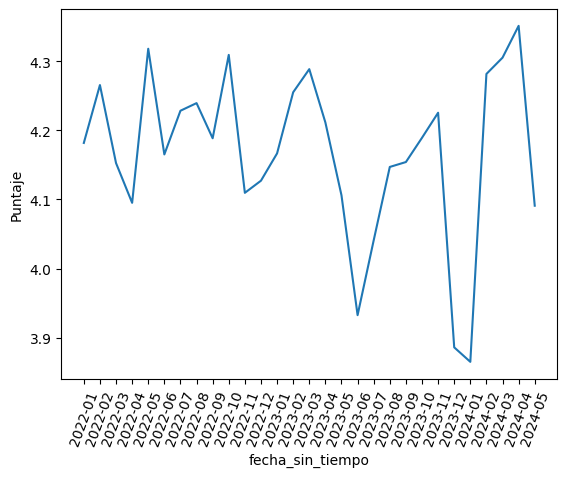

In [79]:
df.groupby('fecha_sin_tiempo')['Puntaje'].mean().reset_index().pipe(
    (sns.lineplot, 'data'), x='fecha_sin_tiempo', y='Puntaje'
                                                                    )
plt.xticks(rotation=70)

# Mostrar el gráfico
plt.show()

 nota algunos valles importantes en este indicador, por ejemplo uno entre marzo de 2023 y julio de 2023, y otro entre finales del 2023 y comienzo del 2024.

# Problemas comunes y áreas de mejoras:

Para ello voy a tomar los comentarios más negativos y buscaré los temas y palabras más frecuentes en los comentarios para identificar oportunidades de mejoras en el servicio y así beneficiar el negocio.

In [146]:
df_neg = df[(df['sentimiento'] == '1 stars') | (df['sentimiento'] == '2 stars')]

In [147]:
# Contar palabras más frecuentes
todas_palabras = ' '.join(df_neg['answer_tokenizado']).split()
contador_palabras = Counter(todas_palabras)

#### Top 20 de palabras más usadas en comentarios que se consideran como negativos:

In [148]:
contador_palabras.most_common(20)

[('variedad', 47),
 ('falta', 44),
 ('ropa', 43),
 ('tallas', 40),
 ('poca', 32),
 ('mas', 26),
 ('prendas', 26),
 ('precios', 25),
 ('atención', 24),
 ('deberían', 23),
 ('talla', 18),
 ('niño', 16),
 ('productos', 15),
 ('tienda', 15),
 ('diseños', 15),
 ('surtido', 13),
 ('demasiado', 13),
 ('tener', 12),
 ('descuentos', 12),
 ('calidad', 12)]

Llama la atención que de las palabras más usadas en este tipo de comentarios son atención, talla, falta, poca, variedad, servicio, atención y surtido, con esto se puede inferir algunas áreas de mejoras.
- La atención al cliente y servicio: es importante, ya que ellos son el activo más valioso, por ende es algo se recomienda mejorar en estos ítems.
- Talla y variedad: Estas las pongo juntas, ya que si un cliente no está satisfecho con una talla deberíamos tener algo de variedad, también si el cliente busca algo en específico deberías tratar en lo posible de disponer una gama de opciones para que los clientes estén satisfechos.

##### Extracción de temas de los comentarios utilizando la técnica de Factorización de Matrices No Negativas (NMF) en combinación con la vectorización TF-IDF

TfidfVectorizer es inicializado con algunos parámetros:  
- max_df: Elimina los términos que aparecen en más del 95% de los documentos. Este parámetro ayuda a eliminar palabras demasiado comunes que no son informativas.  
- min_df: Elimina los términos que aparecen en menos de 2 documentos. Este parámetro ayuda a eliminar palabras demasiado raras que pueden ser ruido.  
- stop_words: Se utilizan para eliminar palabras comunes que no aportan mucho significado al análisis. 
 
NMF es inicializado con algunos parámetros
- n_components: Especifica el número de temas que se desean extraer de los comentarios, en este caso, se han especificado 5 temas.  
- random_state: Controla la aleatoriedad del algoritmo. Establecer un valor fijo 


In [115]:
stop_words_2 = stopwords.words('spanish')

# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_2)
tfidf = tfidf_vectorizer.fit_transform(df_neg['answer_tokenizado'])

# Ajustar el modelo NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(tfidf)

# Mostrar los temas
def mostrar_temas(modelo, vectorizador, n_top_palabras):
    palabras = vectorizador.get_feature_names_out()
    for i, tema in enumerate(modelo.components_):
        print(f"Tema {i}:")
        print(" ".join([palabras[i] for i in tema.argsort()[:-n_top_palabras - 1:-1]]))

mostrar_temas(nmf_model, tfidf_vectorizer, 10)

Tema 0:
ninguno ahora particular asesores hoy mejor preferencial pagar diciembre tipo
Tema 1:
atención mala pésima cliente personal tienda cajera falta parte atiende
Tema 2:
falta variedad tallas surtido poca niño niños productos grandes mas
Tema 3:
ropa linda meses toda mas calidad niños offcorss niño compre
Tema 4:
tienda deberían promociones solo descuento hacer talla prendas precios si


Como podemos ver y confirmar algunas oportunidades de mejoras como lo dijimos anteriormente:  
- Mejorar la atención al cliente de parte del personal que atiende
- Variedad en las tallas y productos
- Pareciera que también se piden los clientes piden hacer uso de promociones

# Características elogiadas

Ahora analizaremos los comentarios positivos para identificar las características más elogiadas por los clientes.

In [151]:
df_pos = df[(df['sentimiento'] == '5 stars') | (df['sentimiento'] == '4 stars')]
df_pos = df_pos[~df_pos['answer_tokenizado'].isnull()]

# Contar palabras más frecuentes
todas_palabras_pos = ' '.join(df_pos['answer_tokenizado']).split()
contador_palabras_pos = Counter(todas_palabras_pos)

#### Top 20 de palabras más usadas en comentarios que se consideran como positivas:

In [153]:
contador_palabras_pos.most_common(20)

[('excelente', 2032),
 ('atención', 1429),
 ('calidad', 1144),
 ('buena', 1137),
 ('gracias', 903),
 ('ropa', 792),
 ('servicio', 756),
 ('marca', 577),
 ('encanta', 548),
 ('productos', 544),
 ('tienda', 464),
 ('prendas', 418),
 ('gusta', 298),
 ('siempre', 291),
 ('buen', 290),
 ('bien', 243),
 ('exelente', 236),
 ('buenos', 230),
 ('excelentes', 225),
 ('precios', 214)]

In [154]:
# Vectorización TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_2)
tfidf = tfidf_vectorizer.fit_transform(df_pos['answer_tokenizado'])

# Ajustar el modelo NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(tfidf)

# Mostrar los temas
def mostrar_temas(modelo, vectorizador, n_top_palabras):
    palabras = vectorizador.get_feature_names_out()
    for i, tema in enumerate(modelo.components_):
        print(f"Tema {i}:")
        print(" ".join([palabras[i] for i in tema.argsort()[:-n_top_palabras - 1:-1]]))

mostrar_temas(nmf_model, tfidf_vectorizer, 10)

Tema 0:
excelente atención calidad servicio tienda marca atencion producto felicitaciones muchas
Tema 1:
atención buena cliente atencion tienda personal parte exelente felicitaciones precios
Tema 2:
gracias muchas atención bien mil existir promociones offcorss siempre excelentes
Tema 3:
calidad ropa encanta marca buena productos prendas gusta excelentes buenos
Tema 4:
servicio buen exelente cliente bien productos bueno felicitaciones producto surtido


#### Características elogiadas:
- La atención al cliente y calidad del servicio
- Buenas promociones
- La calidad de los productos 

# Conclusiones:

Este análisis permitió observar como ven los clientes a la empresa, sus opiniones tanto negativas como positivas, lo que nos mostró algunas características y oportunidades de mejora, como también algunos problemas comunes y áreas de mejora, este es un resumen de lo anterior dicho

- En general las personas y los clientes se llevan una buena imagen de Offcorss, esto se ve que son mucho más la proposición de comentarios buenos
- Hay algunas oportunidades de mejora en la variabilidad de los productos y tallas a ofrecer
- Los clientes resaltan la calidad de los productos y general quedan satisfechos
- A gusto con las promociones

##### Muchas gracias